In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
#dataset
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Medium Dataset/medium_data.csv'
medium_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
medium_data.head()

Mounted at /content/drive


,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [ ]:
medium_data['title']

,title
0,A Beginner’s Guide to Word Embedding with Gens...
1,Hands-on Graph Neural Networks with PyTorch & ...
2,How to Use ggplot2 in Python
3,Databricks: How to Save Files in CSV on Your L...
4,A Step-by-Step Implementation of Gradient Desc...
...,...
6503,“We” vs “I” — How Should You Talk About Yourse...
6504,How Donald Trump Markets Himself
6505,Content and Marketing Beyond Mass Consumption
6506,5 Questions All Copywriters Should Ask Clients...


In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [ ]:
#Tokenization
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Embedding(total_words, 100))  # Remove input_length
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

# Use learning_rate instead of lr
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(xs, ys, epochs=50, verbose=1)

# Print the model summary
#print(model.summary())
print(model)


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 334s 217ms/step - accuracy: 0.1024 - loss: 7.0373
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 315s 208ms/step - accuracy: 0.1770 - loss: 5.7005
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 319s 206ms/step - accuracy: 0.2129 - loss: 4.8320
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 305s 195ms/step - accuracy: 0.2606 - loss: 4.0690
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 318s 193ms/step - accuracy: 0.2722 - loss: 4.1540
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 325s 195ms/step - accuracy: 0.3407 - loss: 3.2906
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 318s 193ms/step - accuracy: 0.3782 - loss: 2.9984
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 326s 196ms/step - accuracy: 0.3986 - loss: 2.8378
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 327s 199ms/step - accuracy: 0.4240 - loss: 2.6729
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 324s 200ms/step - accuracy: 0.4336 - loss: 2.5927
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 320s 199ms/step - accuracy: 0.4505 -

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

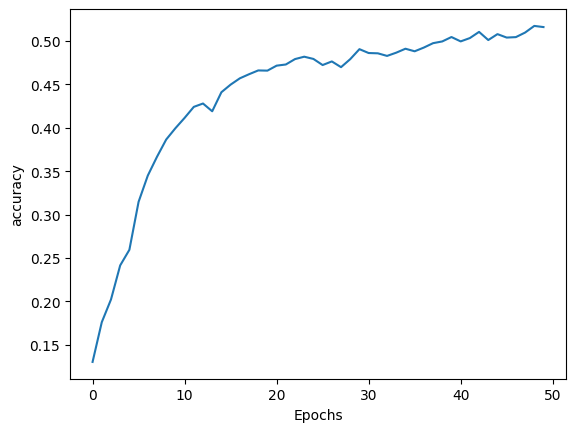

In [ ]:
plot_graphs(history, 'accuracy')

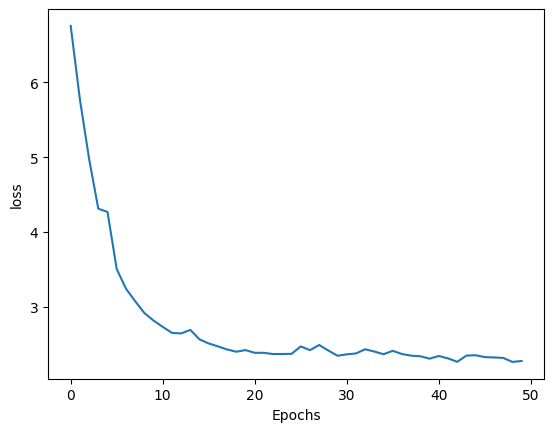

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
# Save the model
model.save('medium_model.h5')
import pickle

# Assuming you have a tokenizer object
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


#### CODEE for UI


In [ ]:
from flask import Flask, render_template, request
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Load the model and tokenizer
model = load_model('model_files/medium_model.h5')
with open('model_files/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Define the maximum sequence length (you should set this to your original max_sequence_len)
max_sequence_len = 50  # Adjust as per your model

app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/generate', methods=['POST'])
def generate():
    seed_text = request.form['seed_text']
    next_words = int(request.form['next_words'])
    generated_text = seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        generated_text += " " + output_word

    return render_template('index.html', generated_text=generated_text)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat



```
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Text Generator</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 50px; }
        input[type="text"] { width: 300px; padding: 10px; }
        input[type="number"] { width: 50px; padding: 10px; }
        button { padding: 10px 15px; }
    </style>
</head>
<body>
    <h1>Text Generator</h1>
    <form method="POST" action="/generate">
        <input type="text" name="seed_text" placeholder="Enter seed text..." required>
        <input type="number" name="next_words" value="2" min="1" required>
        <button type="submit">Generate</button>
    </form>
    
    {% if generated_text %}
        <h2>Generated Text:</h2>
        <p>{{ generated_text }}</p>
    {% endif %}
</body>
</html>

```

